### 🧩 Needed Imports


In [2]:
import math
from typing import List, Dict
import random
from typing import Tuple
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import joblib
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import json
import seaborn as sns
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import os
from sklearn.metrics import accuracy_score, roc_curve
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from matplotlib.ticker import PercentFormatter
import time
from lightgbm import LGBMRegressor

In [12]:
def aggregate_taskset_features(df: pd.DataFrame, include_ml_engineered_features: bool = False,
                               include_schedulable: bool = False) -> pd.DataFrame:
    df = df.copy()

    # Derived per-task features (always computed, but may or may not be aggregated)
    df['criticality'] = df['C'] / df['D']
    df['interference'] = df['C'] / df['T']
    df['harmonicity'] = df.groupby('taskset_id')['T'].transform(lambda x: len(set(x)) / len(x))

    # Base aggregation functions
    agg_funcs = {
        'C': ['mean', 'max', 'min', 'std'],
        'D': ['mean', 'max', 'min', 'std'],
        'U': ['mean', 'max', 'min', 'std'],
        'inv_T': ['mean', 'std'],
        'hp_util': ['mean', 'std'],
        'U_total': 'first',
        'n_tasks': 'first'
    }

    # Optional ML-engineered features
    if include_ml_engineered_features:
        agg_funcs['criticality'] = 'mean'
        agg_funcs['interference'] = 'max'
        agg_funcs['harmonicity'] = 'mean'

    if include_schedulable:
        agg_funcs['schedulable'] = lambda x: 1 if all(x == 1) else 0

    # Group and aggregate
    df_grouped = df.groupby("taskset_id").agg(agg_funcs)

    # Clean column names
    df_grouped.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df_grouped.columns.values]
    if include_schedulable:
        df_grouped.rename(columns={'schedulable_<lambda>': 'schedulable'}, inplace=True)
    df_grouped.reset_index(drop=True, inplace=True)

    return df_grouped

In [13]:
def prepare_dataset_classification(csv_path, include_ml_engineered_features=False):
    df = pd.read_csv(csv_path)
    df_grouped = aggregate_taskset_features(df, include_ml_engineered_features=include_ml_engineered_features,
                                            include_schedulable=True)

    X = df_grouped.drop(columns=["schedulable"])
    y = df_grouped["schedulable"]

    return train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

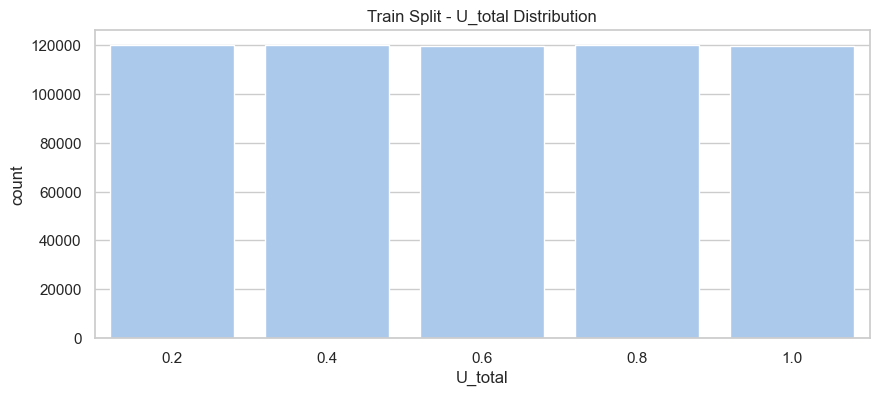

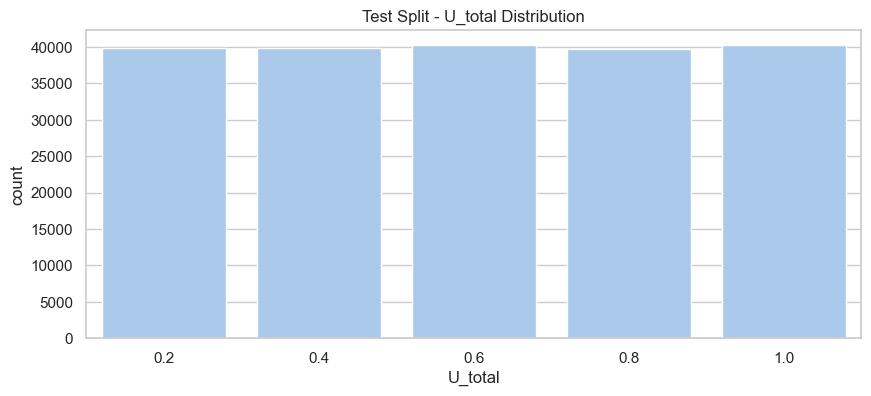

In [14]:
X_train, X_test, y_train, y_test = prepare_dataset_classification("../data/main_dataset.csv",
                                                                  include_ml_engineered_features=True)

# Recover U_total
X_train["U_total"] = X_train["U_total_first"]
X_test["U_total"] = X_test["U_total_first"]

plt.figure(figsize=(10, 4))
sns.countplot(x=X_train["U_total"], order=sorted(X_train["U_total"].unique()))
plt.title("Train Split - U_total Distribution")
plt.show()

plt.figure(figsize=(10, 4))
sns.countplot(x=X_test["U_total"], order=sorted(X_test["U_total"].unique()))
plt.title("Test Split - U_total Distribution")
plt.show()

In [15]:
def train_classification_models(X_train, y_train, model_type, variant="default"):
    if model_type == "random_forest":
        clf = RandomForestClassifier(
            n_estimators=100, max_depth=10, class_weight='balanced',
            random_state=42, n_jobs=-1)
    elif model_type == "logistic_regression":
        clf = LogisticRegression(
            max_iter=1000, class_weight='balanced', random_state=42)
    elif model_type == "xgboost":
        clf = XGBClassifier(
            n_estimators=100, max_depth=6,
            scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
            eval_metric='logloss')
    else:
        raise ValueError("Unsupported model type")

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', clf)
    ])

    pipeline.fit(X_train, y_train)
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5)
    mean_cv = cv_scores.mean()
    std_cv = cv_scores.std()
    cv_results = {
        "model": model_type,
        "variant": variant,
        "cv_mean_accuracy": mean_cv,
        "cv_std": std_cv,
        "cv_scores": cv_scores.tolist()
    }

    # Save CV results with variant tag
    filename = f"../models/classification_models/{model_type}_{variant}_cv.json"
    with open(filename, "w") as f:
        json.dump(cv_results, f, indent=2)

    return pipeline

In [16]:
def evaluate_models(X_test, y_test, model_paths, variant="default"):
    results = []
    plt.figure(figsize=(8, 6))

    for model_name, model_path in model_paths.items():
        pipeline = joblib.load(model_path)
        y_pred = pipeline.predict(X_test)
        y_proba = pipeline.predict_proba(X_test)[:, 1]

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_proba)
        conf = confusion_matrix(y_test, y_pred)

        # 🔍 Try to load and display CV results
        cv_info = "N/A"
        cv_path = f"../models/classification_models/{model_name}_{variant}_cv.json"
        if os.path.exists(cv_path):
            with open(cv_path, "r") as f:
                cv_data = json.load(f)
                cv_info = f"{cv_data['cv_mean_accuracy']:.4f} ± {cv_data['cv_std']:.4f}"

        results.append({
            "Model": model_name,
            "Accuracy": acc,
            "F1 Score": f1,
            "ROC-AUC": roc_auc,
            "FP": conf[0][1],
            "FN": conf[1][0],
            "CV Accuracy": cv_info
        })

        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.3f})")

        print(f"\n=== {model_name.upper()} ===")
        print(f"CV Accuracy: {cv_info}")
        print("Confusion Matrix:\n", conf)
        print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

    plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve Comparison")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Feature Importance for XGBoost
    if "xgboost" in model_paths:
        xgb_model = joblib.load(model_paths["xgboost"])
        importances = xgb_model.named_steps['clf'].feature_importances_
        feature_names = X_test.columns
        sorted_idx = np.argsort(importances)[::-1]

        plt.figure(figsize=(10, 6))
        sns.barplot(x=importances[sorted_idx], y=feature_names[sorted_idx])
        plt.title("XGBoost Feature Importances")
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.show()

    return pd.DataFrame(results)


🔍 STEP 1: Training Models WITHOUT ML-Engineered Features
📦 random_forest (basic) already trained.
📦 logistic_regression (basic) already trained.
📦 xgboost (basic) already trained.

=== RANDOM_FOREST ===
CV Accuracy: 0.8440 ± 0.0013
Confusion Matrix:
 [[132173  26498]
 [  4852  36477]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9646    0.8330    0.8940    158671
           1     0.5792    0.8826    0.6994     41329

    accuracy                         0.8433    200000
   macro avg     0.7719    0.8578    0.7967    200000
weighted avg     0.8850    0.8433    0.8538    200000


=== LOGISTIC_REGRESSION ===
CV Accuracy: 0.8476 ± 0.0012
Confusion Matrix:
 [[132643  26028]
 [  4284  37045]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9687    0.8360    0.8975    158671
           1     0.5873    0.8963    0.7097     41329

    accuracy                         0.8484    200000
   macro 

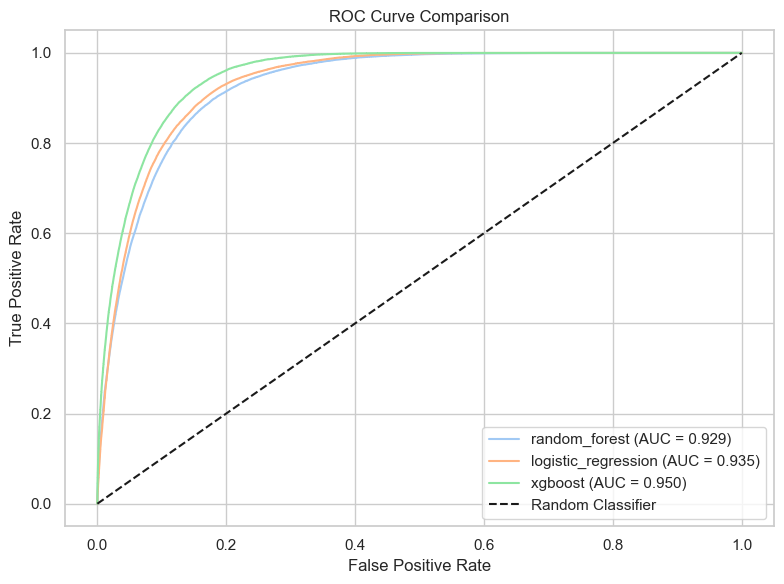

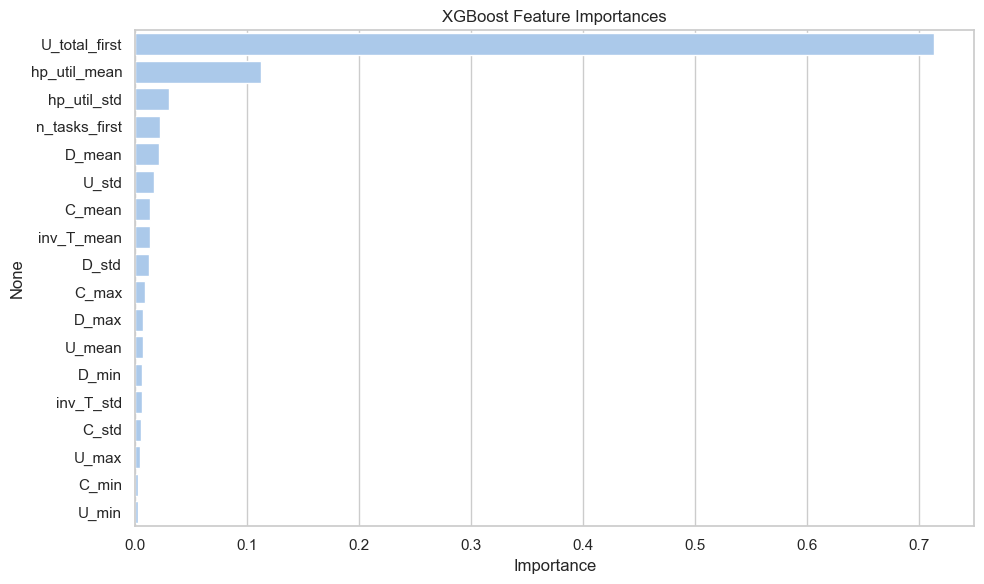


🧪 Evaluation (No Engineered Features)
--------------------------------------------------
                 Model  Accuracy  F1 Score   ROC-AUC     FP    FN  \
0        random_forest  0.843250  0.699436  0.928634  26498  4852   
1  logistic_regression  0.848440  0.709661  0.934953  26028  4284   
2              xgboost  0.866395  0.739132  0.950176  23247  3474   

       CV Accuracy  
0  0.8440 ± 0.0013  
1  0.8476 ± 0.0012  
2  0.8656 ± 0.0011  



🔬 STEP 2: Training Models WITH ML-Engineered Features
📦 random_forest (engineered) already trained.
📦 logistic_regression (engineered) already trained.
📦 xgboost (engineered) already trained.

=== RANDOM_FOREST ===
CV Accuracy: 0.8924 ± 0.0009
Confusion Matrix:
 [[140207  18464]
 [  2772  38557]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9806    0.8836    0.9296    158671
           1     0.6762    0.9329    0.7841     41329

    accuracy                         0.8938    200000
   mac

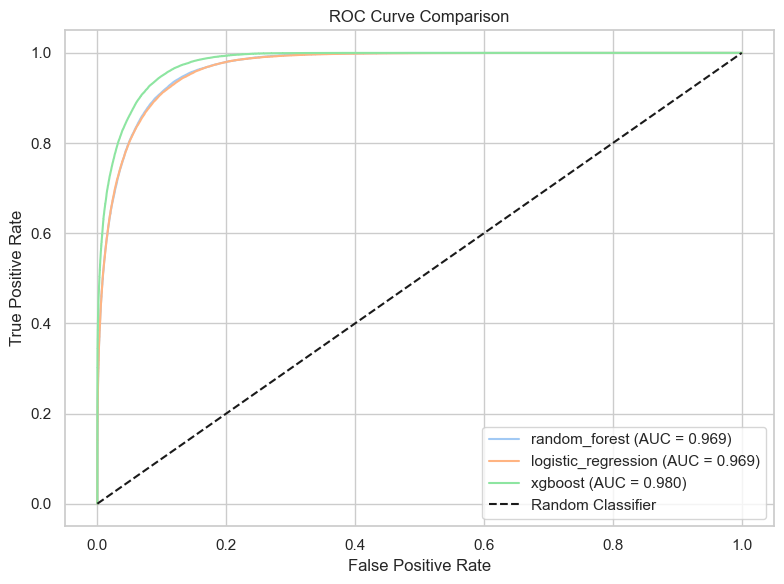

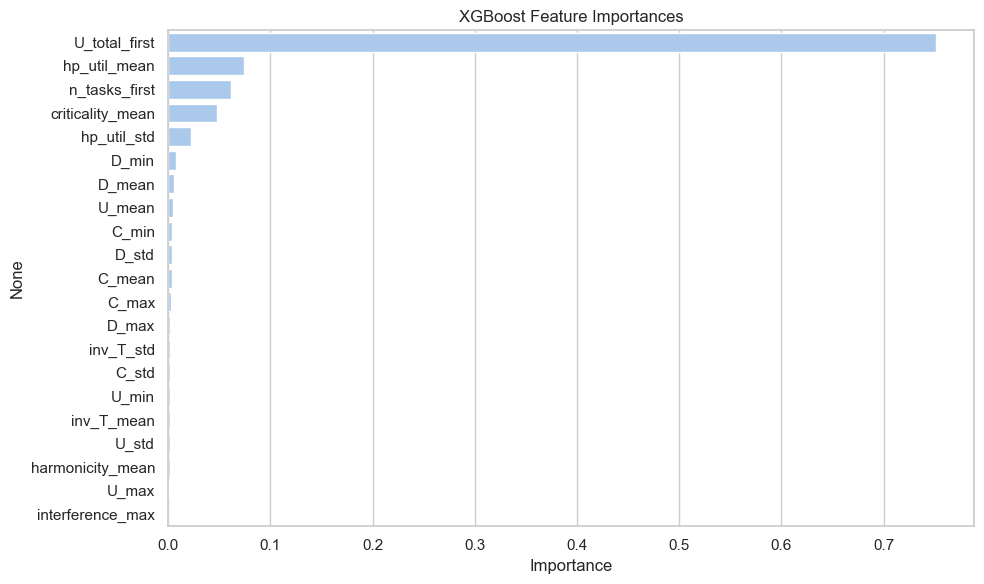


🧪 Evaluation (With Engineered Features)
--------------------------------------------------
                 Model  Accuracy  F1 Score   ROC-AUC     FP    FN  \
0        random_forest  0.893820  0.784077  0.969459  18464  2772   
1  logistic_regression  0.894935  0.784219  0.968926  17868  3145   
2              xgboost  0.913855  0.818804  0.979664  14828  2401   

       CV Accuracy  
0  0.8924 ± 0.0009  
1  0.8941 ± 0.0012  
2  0.9128 ± 0.0009  


In [19]:
# --- Step 1: Basic Features (No ML-Engineered Features)
print("=" * 50)
print("🔍 STEP 1: Training Models WITHOUT ML-Engineered Features")
print("=" * 50)

X_train_basic, X_test_basic, y_train_basic, y_test_basic = prepare_dataset_classification(
    "../data/main_dataset.csv", include_ml_engineered_features=False)

for model_type in ["random_forest", "logistic_regression", "xgboost"]:
    model_path = f"../models/classification_models/{model_type}_basic.pkl"
    if not os.path.exists(model_path):
        print(f"🚀 Training {model_type} (basic)...")
        pipeline = train_classification_models(X_train_basic, y_train_basic, model_type, variant="basic")
        joblib.dump(pipeline, model_path)
    else:
        print(f"📦 {model_type} (basic) already trained.")

results_basic = evaluate_models(X_test_basic, y_test_basic, {
    "random_forest": "classification_models/random_forest_basic.pkl",
    "logistic_regression": "classification_models/logistic_regression_basic.pkl",
    "xgboost": "classification_models/xgboost_basic.pkl"
}, variant="basic")

print("\n🧪 Evaluation (No Engineered Features)")
print("-" * 50)
print(results_basic)
print("\n\n")

# --- Step 2: With Engineered Features
print("=" * 50)
print("🔬 STEP 2: Training Models WITH ML-Engineered Features")
print("=" * 50)

X_train_eng, X_test_eng, y_train_eng, y_test_eng = prepare_dataset_classification(
    "../data/main_dataset.csv", include_ml_engineered_features=True)

for model_type in ["random_forest", "logistic_regression", "xgboost"]:
    model_path = f"../models/classification_models/{model_type}_engineered.pkl"
    if not os.path.exists(model_path):
        print(f"🚀 Training {model_type} (engineered)...")
        pipeline = train_classification_models(X_train_eng, y_train_eng, model_type, variant="engineered")
        joblib.dump(pipeline, model_path)
    else:
        print(f"📦 {model_type} (engineered) already trained.")

results_eng = evaluate_models(X_test_eng, y_test_eng, {
    "random_forest": "classification_models/random_forest_engineered.pkl",
    "logistic_regression": "classification_models/logistic_regression_engineered.pkl",
    "xgboost": "classification_models/xgboost_engineered.pkl"
}, variant="engineered")

print("\n🧪 Evaluation (With Engineered Features)")
print("-" * 50)
print(results_eng)


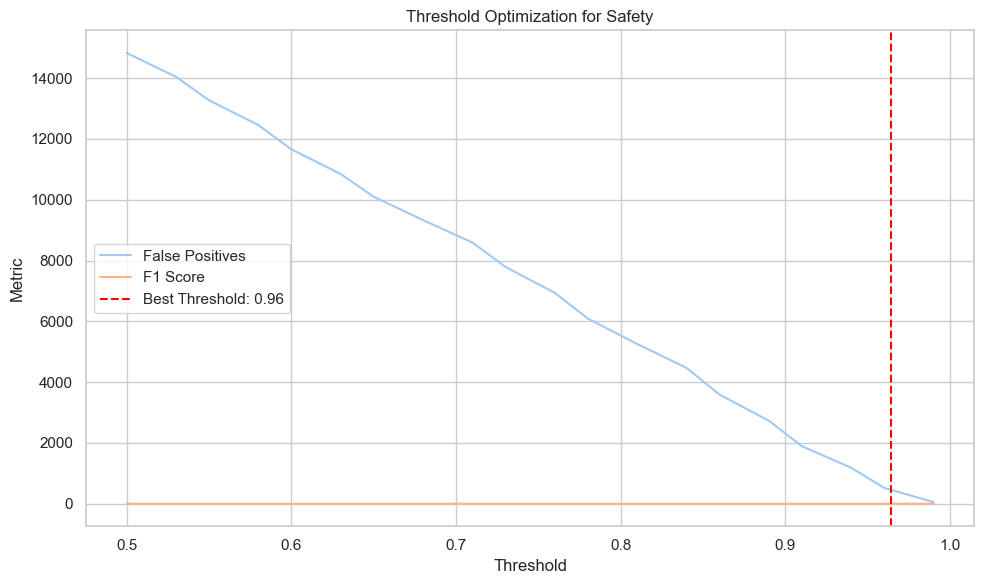


🔍 Top Threshold Results:
    Threshold  False Positives  False Negatives  F1 Score  Precision  \
19       0.99               54            27173  0.509768   0.996200   
18       0.96              520            20537  0.663846   0.975601   
17       0.94             1181            16705  0.733578   0.954234   
16       0.91             1891            14012  0.774544   0.935257   
15       0.89             2727            11976  0.799711   0.914994   

    Underestimation Risk  
19              0.000270  
18              0.002600  
17              0.005905  
16              0.009455  
15              0.013635  

✅ Best Threshold: 0.96


In [94]:
# STEP 1: Evaluate Thresholds + Safety Metrics
def evaluate_with_threshold(X_test, y_test, pipeline):
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    thresholds = np.linspace(0.5, 0.99, 20)

    best_threshold = 0.5
    best_fp = float('inf')
    best_f1 = 0.0
    logs = []

    for thresh in thresholds:
        y_pred = (y_proba >= thresh).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        f1 = f1_score(y_test, y_pred)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        underrisk = fp / len(y_test)
        if fp < best_fp and f1 > 0.6:
            best_fp, best_f1, best_threshold = fp, f1, thresh
        logs.append({
            'Threshold': round(thresh, 2),
            'False Positives': fp,
            'False Negatives': fn,
            'F1 Score': f1,
            'Precision': precision,
            'Underestimation Risk': underrisk
        })

    # Plot
    logs_df = pd.DataFrame(logs)
    plt.figure(figsize=(10, 6))
    plt.plot(logs_df["Threshold"], logs_df["False Positives"], label="False Positives")
    plt.plot(logs_df["Threshold"], logs_df["F1 Score"], label="F1 Score")
    plt.axvline(best_threshold, color='red', linestyle='--', label=f"Best Threshold: {best_threshold:.2f}")
    plt.title("Threshold Optimization for Safety")
    plt.xlabel("Threshold")
    plt.ylabel("Metric")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return logs_df, best_threshold


# STEP 2: Run Entire Pipeline
def run_pipeline(csv_path):
    X_train, X_test, y_train, y_test = prepare_dataset_classification(csv_path, include_ml_engineered_features=True)
    model = joblib.load("../models/classification_models/xgboost_engineered.pkl")
    logs_df, best_threshold = evaluate_with_threshold(X_test, y_test, model)

    return logs_df, best_threshold, model, X_test, y_test


# === RUN ===
logs_df, best_threshold, model, X_test, y_test = run_pipeline("../data/main_dataset.csv")

# Show top 5 thresholds
print("\n🔍 Top Threshold Results:")
print(logs_df.sort_values("False Positives").head(5))
print(f"\n✅ Best Threshold: {best_threshold:.2f}")

In [99]:
tasks, U_total = generate_task_list(n=10, U_total=0.9, taskset_id=1)
df = pd.DataFrame(tasks)
print(df)
df_agg = aggregate_taskset_features(df, include_ml_engineered_features=True, include_schedulable=False)

model = joblib.load("../models/classification_models/xgboost_engineered.pkl")

# Get probability
y_proba = model.predict_proba(df_agg)[:, 1]

# Apply chosen safety threshold (e.g., 0.96)
y_pred = (y_proba >= 0.96).astype(int)

labeled_tasks = perform_rta_analysis(tasks=tasks)
true_schedulable = int(all(t["schedulable"] == 1 for t in labeled_tasks))
print("------------")
print(pd.DataFrame(labeled_tasks))

print("Prediction:", y_pred[0])  # 1 = safe, 0 = unsafe
print("Probability:", y_proba[0])
print("Ground Truth:", true_schedulable)


     T          C    D         U  n_tasks  task_id  taskset_id   hp_util  \
0   20   1.673092    3  0.083655       10        0           1  0.000000   
1   40   0.554169    6  0.013854       10        1           1  0.083655   
2   20   0.063866    7  0.003193       10        2           1  0.097509   
3   10   1.798161    8  0.179816       10        3           1  0.100702   
4  640   4.518913   11  0.007061       10        4           1  0.280518   
5   80   6.880974   12  0.086012       10        5           1  0.287579   
6   20   0.243378   17  0.012169       10        6           1  0.373591   
7  160   4.667207  109  0.029170       10        7           1  0.385760   
8  155  60.402119  112  0.389691       10        8           1  0.414930   
9  640  61.042442  115  0.095379       10        9           1  0.804621   

      inv_T  U_total  
0  0.050000      0.9  
1  0.025000      0.9  
2  0.050000      0.9  
3  0.100000      0.9  
4  0.001563      0.9  
5  0.012500      0.9  
6 

✅ Number of rows in df_results: 1500
✅ Columns in df_results: ['taskset_id', 'n_tasks', 'U_total', 'y_pred', 'y_proba', 'ground_truth', 'false_positive', 'false_negative']

📊 Detailed Classification Summary by Utilization

🔹 Utilization: 0.2
   - Total Tasksets             : 300.0
   - Ground Truth Schedulable   : 212.0
     └── Correctly Predicted    : 137.0 ✅
   - Ground Truth Unschedulable : 88.0
     └── Correctly Predicted    : 82.0 ✅
   - Accuracy                   : 73.00%

🔹 Utilization: 0.4
   - Total Tasksets             : 300.0
   - Ground Truth Schedulable   : 92.0
     └── Correctly Predicted    : 37.0 ✅
   - Ground Truth Unschedulable : 208.0
     └── Correctly Predicted    : 207.0 ✅
   - Accuracy                   : 81.33%

🔹 Utilization: 0.6
   - Total Tasksets             : 300.0
   - Ground Truth Schedulable   : 27.0
     └── Correctly Predicted    : 11.0 ✅
   - Ground Truth Unschedulable : 273.0
     └── Correctly Predicted    : 273.0 ✅
   - Accuracy                 

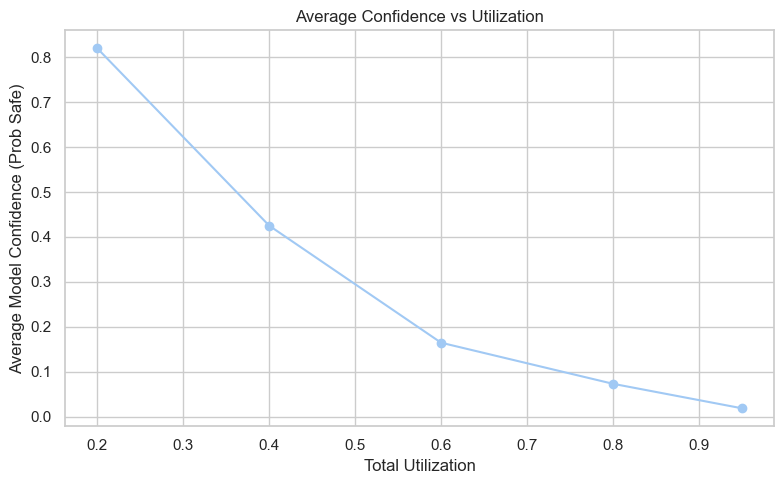

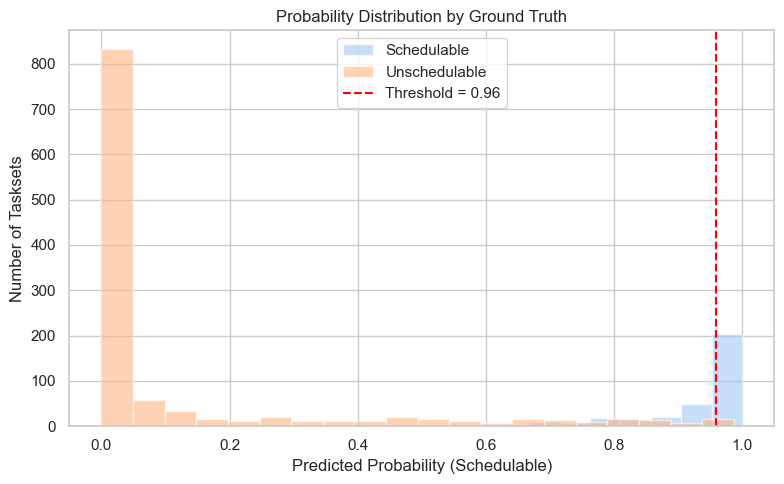

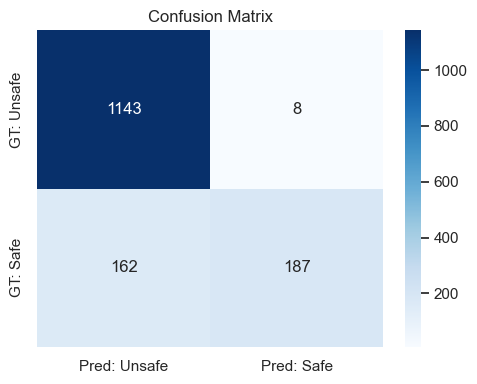

📈 Model Performance Summary (Based on Confusion Matrix)
-------------------------------------------------------
✅ Accuracy              = (1143 + 187) / 1500 = 88.67%
✅ Precision (Schedulable) = 187 / (187 + 8) = 95.90%
⚠️  Recall (Schedulable)    = 187 / (187 + 162) = 53.58%
✅ False Positive Rate   = 8 / (8 + 1143) = 0.70%


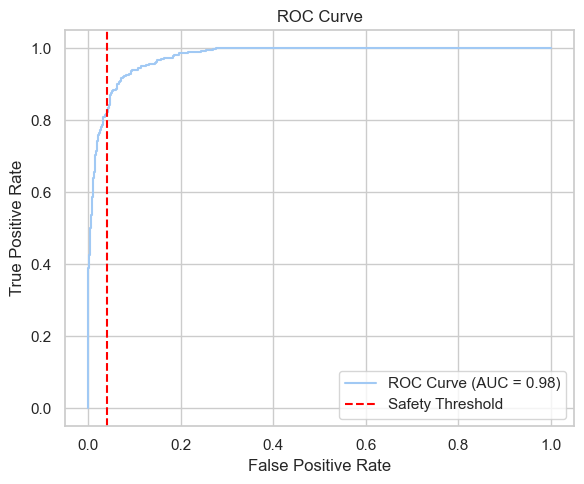

In [101]:
model_path = "../models/classification_models/xgboost_engineered.pkl"
n_values = [5, 10, 15]
utilization_bins = [0.2, 0.4, 0.6, 0.8, 0.95]
samples_per_bin = 100
threshold = 0.96

# Load model
model = joblib.load(model_path)

results = []
taskset_id = 0
random.seed(11)
np.random.seed(11)

for U in utilization_bins:
    for n in n_values:
        for _ in range(samples_per_bin):
            tasks, U_total = generate_task_list(n=n, U_total=U, taskset_id=taskset_id, )
            labeled = perform_rta_analysis(tasks)
            df = pd.DataFrame(labeled)
            df_agg = aggregate_taskset_features(df, include_ml_engineered_features=True, include_schedulable=False)
            proba = float(model.predict_proba(df_agg)[0, 1])
            pred = int(proba >= threshold)
            gt = int(all(t["schedulable"] == 1 for t in labeled))

            results.append({
                "taskset_id": taskset_id,
                "n_tasks": n,
                "U_total": U,
                "y_pred": pred,
                "y_proba": proba,
                "ground_truth": gt,
                "false_positive": int(pred == 1 and gt == 0),
                "false_negative": int(pred == 0 and gt == 1)
            })

            taskset_id += 1

df_results = pd.DataFrame(results)
print("✅ Number of rows in df_results:", len(df_results))
print("✅ Columns in df_results:", df_results.columns.tolist())
summary = []

for u in sorted(df_results["U_total"].unique()):
    subset = df_results[df_results["U_total"] == u]

    total = len(subset)

    # Ground Truth Breakdown
    schedulable = subset[subset["ground_truth"] == 1]
    unschedulable = subset[subset["ground_truth"] == 0]

    gt_schedulable = len(schedulable)
    gt_unschedulable = len(unschedulable)

    # Correct Predictions per category
    correct_schedulable = (schedulable["y_pred"] == 1).sum()
    correct_unschedulable = (unschedulable["y_pred"] == 0).sum()

    # Overall accuracy
    total_correct = correct_schedulable + correct_unschedulable
    accuracy = round(100 * total_correct / total, 2)

    summary.append({
        "Utilization": u,
        "Total Tasksets": total,
        "Schedulable (GT=1)": gt_schedulable,
        "Unschedulable (GT=0)": gt_unschedulable,
        "Correct GT=1": correct_schedulable,
        "Correct GT=0": correct_unschedulable,
        "Accuracy (%)": accuracy
    })

# Create DataFrame and print
summary_df = pd.DataFrame(summary)

# Pretty Print
summary_str = "\n📊 Detailed Classification Summary by Utilization\n"
for i, row in summary_df.iterrows():
    summary_str += (
        f"\n🔹 Utilization: {row['Utilization']}\n"
        f"   - Total Tasksets             : {row['Total Tasksets']}\n"
        f"   - Ground Truth Schedulable   : {row['Schedulable (GT=1)']}\n"
        f"     └── Correctly Predicted    : {row['Correct GT=1']} ✅\n"
        f"   - Ground Truth Unschedulable : {row['Unschedulable (GT=0)']}\n"
        f"     └── Correctly Predicted    : {row['Correct GT=0']} ✅\n"
        f"   - Accuracy                   : {row['Accuracy (%)']:.2f}%\n"
    )

print(summary_str)

classification_summary = classification_report(
    df_results["ground_truth"],
    df_results["y_pred"],
    output_dict=True
)
classification_df = pd.DataFrame(classification_summary).transpose()

# -- Numerical Summary 2: False positives/negatives per utilization bin
utilization_stats = df_results.groupby("U_total")[["false_positive", "false_negative"]].sum()
utilization_stats["total"] = df_results.groupby("U_total").size()
utilization_stats["fp_rate"] = utilization_stats["false_positive"] / utilization_stats["total"]
utilization_stats["fn_rate"] = utilization_stats["false_negative"] / utilization_stats["total"]

# -- Numerical Summary 3: False positives/negatives per task count bin
taskcount_stats = df_results.groupby("n_tasks")[["false_positive", "false_negative"]].sum()
taskcount_stats["total"] = df_results.groupby("n_tasks").size()
taskcount_stats["fp_rate"] = taskcount_stats["false_positive"] / taskcount_stats["total"]
taskcount_stats["fn_rate"] = taskcount_stats["false_negative"] / taskcount_stats["total"]

import seaborn as sns
import matplotlib.pyplot as plt

# -- Visualization 1: Confidence vs Utilization
plt.figure(figsize=(8, 5))
df_results.groupby("U_total")["y_proba"].mean().plot(marker='o')
plt.title("Average Confidence vs Utilization")
plt.xlabel("Total Utilization")
plt.ylabel("Average Model Confidence (Prob Safe)")
plt.grid(True)
plt.tight_layout()
plt.show()

# -- Visualization 2: Histogram of Probabilities
plt.figure(figsize=(8, 5))
df_results[df_results["ground_truth"] == 1]["y_proba"].hist(alpha=0.6, bins=20, label="Schedulable")
df_results[df_results["ground_truth"] == 0]["y_proba"].hist(alpha=0.6, bins=20, label="Unschedulable")
plt.axvline(x=0.96, color='red', linestyle='--', label="Threshold = 0.96")
plt.title("Probability Distribution by Ground Truth")
plt.xlabel("Predicted Probability (Schedulable)")
plt.ylabel("Number of Tasksets")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -- Visualization 3: Confusion Matrix
cm = confusion_matrix(df_results["ground_truth"], df_results["y_pred"])
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=["Pred: Unsafe", "Pred: Safe"],
            yticklabels=["GT: Unsafe", "GT: Safe"])
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

tn, fp, fn, tp = cm.ravel()

# Compute metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
false_positive_rate = fp / (fp + tn) if (fp + tn) > 0 else 0

# Print results
print("📈 Model Performance Summary (Based on Confusion Matrix)")
print("-------------------------------------------------------")
print(f"✅ Accuracy              = ({tn} + {tp}) / {tn + tp + fp + fn} = {accuracy:.2%}")
print(f"✅ Precision (Schedulable) = {tp} / ({tp} + {fp}) = {precision:.2%}")
print(f"⚠️  Recall (Schedulable)    = {tp} / ({tp} + {fn}) = {recall:.2%}")
print(f"✅ False Positive Rate   = {fp} / ({fp} + {tn}) = {false_positive_rate:.2%}")

# -- Visualization 4: ROC Curve
roc_auc = roc_auc_score(df_results["ground_truth"], df_results["y_proba"])
fpr, tpr, _ = roc_curve(df_results["ground_truth"], df_results["y_proba"])
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.axvline(x=(1 - 0.96), color="red", linestyle="--", label="Safety Threshold")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Regression




In [129]:
def prepare_regression_dataset(csv_path):
    """
    Load and preprocess the dataset for regression.
    Filters to only schedulable tasks and computes derived features.

    Returns:
        X_train, X_test, y_train, y_test
    """
    df = pd.read_csv(csv_path)
    df_sched = df[df['schedulable'] == 1].copy()

    df_sched['C_div_T'] = df_sched['C'] / df_sched['T']
    df_sched['slack'] = df_sched['D'] - df_sched['C']
    df_sched['criticality'] = df_sched['C'] / df_sched['D']
    df_sched['interference'] = df_sched['C'] / df_sched['T']

    feature_cols = [
        'C', 'D', 'T', 'inv_T', 'hp_util', 'U_total', 'n_tasks',
        'C_div_T', 'slack', 'criticality', 'interference'
    ]
    target_col = 'R_true'

    X = df_sched[feature_cols]
    y = df_sched[target_col]

    return train_test_split(X, y, test_size=0.25, random_state=42)

In [130]:
def train_regressor(X_train, y_train, model_type, model_output_path=None):
    if model_output_path is None:
        model_output_path = f"../models/regression_models/{model_type}_regressor.pkl"

    if os.path.exists(model_output_path):
        print(f"📦 {model_type} already trained. Loading existing model.")
        return joblib.load(model_output_path), model_output_path

    if model_type == "linear_regression":
        model = LinearRegression()

    elif model_type == "random_forest":
        model = RandomForestRegressor(
            n_estimators=100, max_depth=12, n_jobs=-1, random_state=42
        )

    elif model_type == "xgboost":
        model = XGBRegressor(
            n_estimators=100, max_depth=6, n_jobs=-1, random_state=42
        )
    else:
        raise ValueError("Unsupported model type")

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('reg', model)
    ])

    pipeline.fit(X_train, y_train)
    joblib.dump(pipeline, model_output_path)
    print(f"✅ Trained and saved model to {model_output_path}")
    return pipeline, model_output_path

In [131]:
def evaluate_regressors(X_test, y_test, model_paths: dict):
    """
    Evaluates and visualizes multiple regression models for WCRT prediction.

    Returns:
        pd.DataFrame: Evaluation summary table.
    """
    results = []
    plt.figure(figsize=(8, 6))

    for model_name, path in model_paths.items():
        pipeline = joblib.load(path)
        y_pred = pipeline.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred) ** 0.5
        r2 = r2_score(y_test, y_pred)
        max_err = np.max(np.abs(y_test - y_pred))
        under_rate = (y_pred < y_test).mean() * 100  # percentage

        results.append({
            "Model": model_name,
            "MAE": mae,
            "RMSE": rmse,
            "R²": r2,
            "Max Error": max_err,
            "Underestimation %": under_rate
        })

        plt.scatter(y_test, y_pred, s=5, alpha=0.3, label=f"{model_name} (R²={r2:.3f})")

        print(f"\n=== {model_name.upper()} REGRESSOR ===")
        print(f"MAE: {mae:.4f}")
        print(f"RMSE: {rmse:.4f}")
        print(f"R²: {r2:.4f}")
        print(f"Max Error: {max_err:.2f} units")
        print(f"Underestimation Rate: {under_rate:.2f}%")

    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', label="Ideal Fit")
    plt.xlabel("True R_true")
    plt.ylabel("Predicted R_true")
    plt.title("True vs Predicted WCRT")
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    df_results = pd.DataFrame(results).sort_values(by="R²", ascending=False)
    return df_results

📦 linear_regression already trained. Loading existing model.
📦 random_forest already trained. Loading existing model.
📦 xgboost already trained. Loading existing model.

=== LINEAR_REGRESSION REGRESSOR ===
MAE: 14.4229
RMSE: 25.8555
R²: 0.7964
Max Error: 414.46 units
Underestimation Rate: 56.31%

=== RANDOM_FOREST REGRESSOR ===
MAE: 6.9421
RMSE: 17.1624
R²: 0.9103
Max Error: 349.34 units
Underestimation Rate: 44.89%

=== XGBOOST REGRESSOR ===
MAE: 6.9321
RMSE: 17.1551
R²: 0.9103
Max Error: 353.08 units
Underestimation Rate: 45.10%


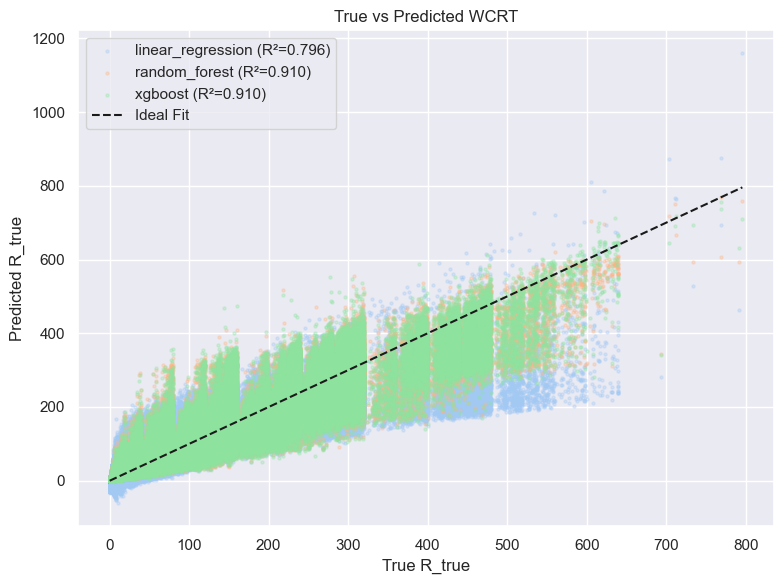

,Model,MAE,RMSE,R²,Max Error,Underestimation %
2,xgboost,6.932138,17.155105,0.910349,353.080184,45.101292
1,random_forest,6.942062,17.162368,0.910273,349.342946,44.891791
0,linear_regression,14.422853,25.855525,0.796355,414.456142,56.309385


In [132]:
X_train, X_test, y_train, y_test = prepare_regression_dataset("main_dataset.csv")

train_regressor(X_train, y_train, model_type="linear_regression")
train_regressor(X_train, y_train, model_type="random_forest")
train_regressor(X_train, y_train, model_type="xgboost")

evaluate_regressors(X_test, y_test, {
    "linear_regression": "regression_models/linear_regression_regressor.pkl",
    "random_forest": "regression_models/random_forest_regressor.pkl",
    "xgboost": "regression_models/xgboost_regressor.pkl"
})

Loading trained model...
Analyzing underestimations...
Running margin sensitivity analysis...

🔍 COMPREHENSIVE UNDER-ESTIMATION ANALYSIS
Total Test Samples:               1,642,474
Underestimated Samples:             740,777 (45.10%)
Median Response Time:                  6.38
Median Underestimation:                1.37
Maximum Underestimation:             353.08

Theoretical Margin Needed for 100% Coverage:       5538.0%

🛡️ MARGIN SENSITIVITY ANALYSIS
Best Achievable Coverage:      77.16% (at 20% margin)
Coverage at 10% Margin:        67.85%
Remaining Unsafe Samples:           528,020

Generating visualizations...


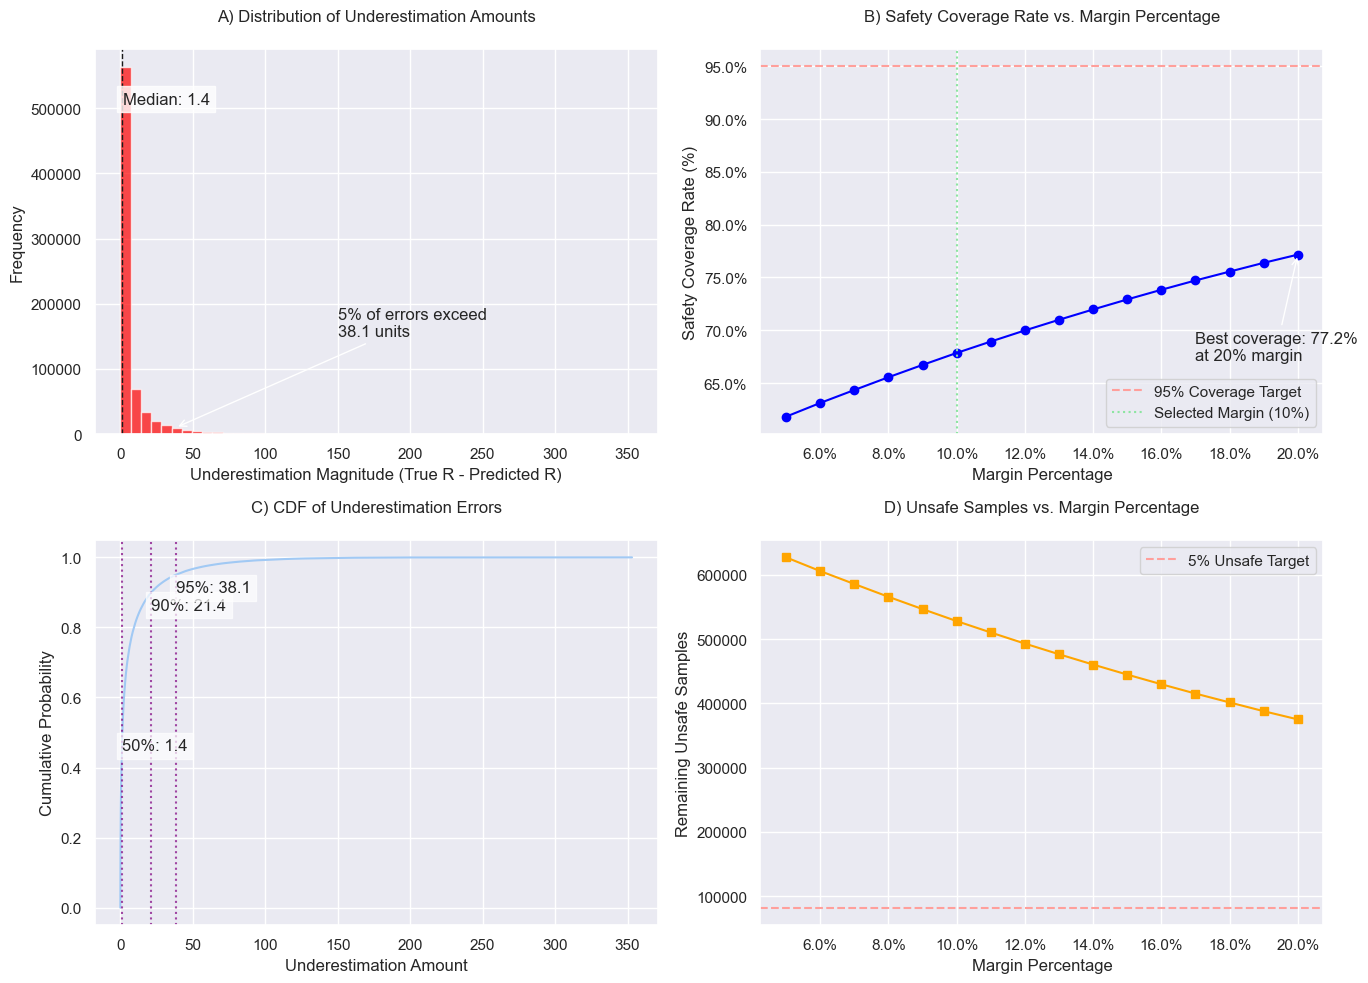


Analysis complete. Visualizations saved to 'underestimation_analysis.png'


In [135]:
X_train, X_test, y_train, y_test = prepare_regression_dataset("main_dataset.csv")

# === STEP 4: Load Trained XGBoost Regressor ===
print("Loading trained model...")
xgb_pipeline = joblib.load("../models/regression_models/xgboost_regressor.pkl")
y_pred = xgb_pipeline.predict(X_test)

# === STEP 5: Underestimation Analysis ===
print("Analyzing underestimations...")
underestimations = y_pred < y_test
num_underestimates = underestimations.sum()
percent_underestimates = 100 * num_underestimates / len(y_test)
under_amounts = (y_test - y_pred)[underestimations]

# Calculate key statistics
median_response = np.median(y_test)
max_underestimation = under_amounts.max()
median_underestimation = np.median(under_amounts)

# === STEP 6: Margin Sensitivity Analysis ===
print("Running margin sensitivity analysis...")
margins = np.linspace(0.05, 0.20, 16)  # 5% to 20% in 1% increments
coverage_rates = []

for margin in margins:
    y_pred_margin = y_pred * (1 + margin)
    coverage_rates.append(100 * (y_pred_margin >= y_test).mean())

# Find best achievable coverage
best_coverage = max(coverage_rates)
best_margin = margins[np.argmax(coverage_rates)]

# === STEP 7: Apply Selected +10% Margin ===
selected_margin = 0.10
y_pred_margin = y_pred * (1 + selected_margin)
safe_with_margin = y_pred_margin >= y_test
num_safe_with_margin = safe_with_margin.sum()
percent_safe_with_margin = 100 * num_safe_with_margin / len(y_test)

# === STEP 8: Print Comprehensive Summary ===
print("\n" + "=" * 50)
print("🔍 COMPREHENSIVE UNDER-ESTIMATION ANALYSIS")
print("=" * 50)
print(f"{'Total Test Samples:':<30} {len(y_test):>12,}")
print(f"{'Underestimated Samples:':<30} {num_underestimates:>12,} ({percent_underestimates:.2f}%)")
print(f"{'Median Response Time:':<30} {median_response:>12.2f}")
print(f"{'Median Underestimation:':<30} {median_underestimation:>12.2f}")
print(f"{'Maximum Underestimation:':<30} {max_underestimation:>12.2f}")
print(f"\n{'Theoretical Margin Needed for 100% Coverage:':<50} {max_underestimation / median_response:.1%}")

print("\n" + "=" * 50)
print("🛡️ MARGIN SENSITIVITY ANALYSIS")
print("=" * 50)
print(f"{'Best Achievable Coverage:':<30} {best_coverage:.2f}% (at {best_margin:.0%} margin)")
print(f"{'Coverage at 10% Margin:':<30} {percent_safe_with_margin:.2f}%")
print(f"{'Remaining Unsafe Samples:':<30} {len(y_test) - num_safe_with_margin:>12,}")

# === STEP 9: Enhanced Plotting ===
print("\nGenerating visualizations...")
plt.figure(figsize=(14, 10))

# Plot 1: Underestimation Histogram
plt.subplot(2, 2, 1)
n, bins, patches = plt.hist(under_amounts, bins=50, color='red', alpha=0.7)
plt.title("A) Distribution of Underestimation Amounts", pad=20)
plt.xlabel("Underestimation Magnitude (True R - Predicted R)")
plt.ylabel("Frequency")
plt.annotate(f"5% of errors exceed\n{np.percentile(under_amounts, 95):.1f} units",
             xy=(np.percentile(under_amounts, 95), 10000),
             xytext=(150, 150000), arrowprops=dict(arrowstyle="->"))
plt.grid(True)

# Add median line
plt.axvline(median_underestimation, color='k', linestyle='dashed', linewidth=1)
plt.text(median_underestimation * 1.1, max(n) * 0.9,
         f'Median: {median_underestimation:.1f}',
         bbox=dict(facecolor='white', alpha=0.8))

# Plot 2: Margin vs Coverage
plt.subplot(2, 2, 2)
plt.plot(margins, coverage_rates, marker='o', linestyle='-', color='blue')
plt.axhline(y=95, color='r', linestyle='--', label='95% Coverage Target')
plt.axvline(x=selected_margin, color='g', linestyle=':', label='Selected Margin (10%)')
plt.title("B) Safety Coverage Rate vs. Margin Percentage", pad=20)
plt.xlabel("Margin Percentage")
plt.ylabel("Safety Coverage Rate (%)")
plt.gca().yaxis.set_major_formatter(PercentFormatter())
plt.gca().xaxis.set_major_formatter(PercentFormatter(1.0))
plt.legend()
plt.grid(True)

# Add annotation
plt.annotate(f"Best coverage: {best_coverage:.1f}%\nat {best_margin:.0%} margin",
             xy=(best_margin, best_coverage),
             xytext=(best_margin - 0.03, best_coverage - 10),
             arrowprops=dict(arrowstyle="->"))

# Plot 3: Cumulative Distribution
plt.subplot(2, 2, 3)
sorted_under = np.sort(under_amounts)
cdf = np.linspace(0, 1, len(sorted_under))
plt.plot(sorted_under, cdf)
plt.title("C) CDF of Underestimation Errors", pad=20)
plt.xlabel("Underestimation Amount")
plt.ylabel("Cumulative Probability")
plt.grid(True)

# Highlight key percentiles
for p in [0.5, 0.9, 0.95]:
    value = np.percentile(under_amounts, p * 100)
    plt.axvline(value, color='purple', linestyle=':', alpha=0.7)
    plt.text(value, p - 0.05, f'{p:.0%}: {value:.1f}',
             bbox=dict(facecolor='white', alpha=0.7))

# Plot 4: Margin Effectiveness
plt.subplot(2, 2, 4)
remaining_unsafe = [len(y_test) - (y_pred * (1 + m) >= y_test).sum() for m in margins]
plt.plot(margins, remaining_unsafe, marker='s', color='orange')
plt.title("D) Unsafe Samples vs. Margin Percentage", pad=20)
plt.xlabel("Margin Percentage")
plt.ylabel("Remaining Unsafe Samples")
plt.gca().xaxis.set_major_formatter(PercentFormatter(1.0))
plt.grid(True)
plt.tight_layout()
plt.axhline(y=len(y_test) * 0.05, color='r', linestyle='--',
            label='5% Unsafe Target')
plt.legend()

plt.savefig('underestimation_analysis.png', dpi=300)
plt.show()

print("\nAnalysis complete. Visualizations saved to 'underestimation_analysis.png'")

🔄 Loading and preprocessing data...
📊 Splitting dataset...
📦 Loading cached model: cqr_lower_model.pkl
📦 Loading cached model: cqr_upper_model.pkl
📏 Running adaptive calibration...
🧠 Predicting on test set...
📦 Loading cached optimized intervals...
📈 Evaluating model...

📊 IMPROVED CQR EVALUATION METRICS
-----------------------------------
MAE (mean abs error)       : 7.6732
Max Absolute Error         : 373.3166
Coverage Rate (95% goal)   : 95.71%
Average Interval Width     : 30.49
Maximum Interval Width     : 493.37
📉 Plotting results...


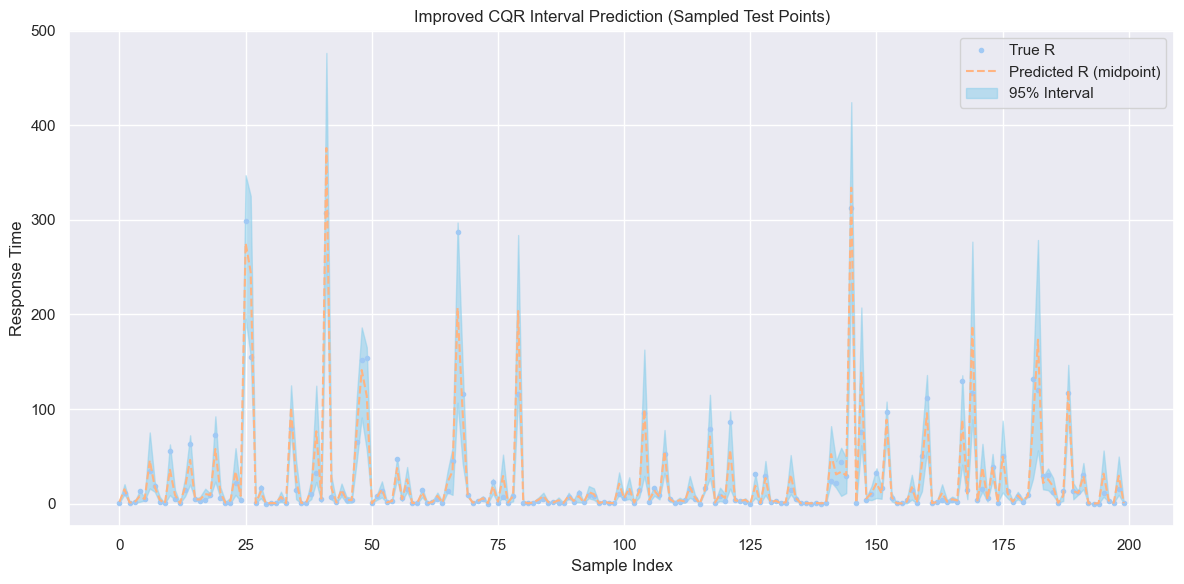


🔎 SAFETY PREDICTION DISTRIBUTION
----------------------------------
Safe Predictions     : 1,257,617 (95.71%)
Unsafe Predictions   : 56,362 (4.29%)


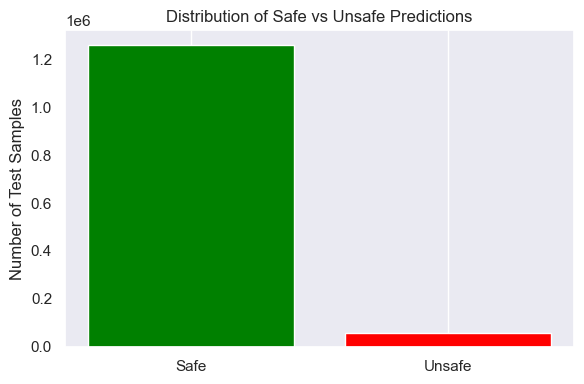


📊 Average WCRT vs Utilization Level
  util_bin     true_R     pred_R  interval_width
0  0.2–0.4  19.785339  22.414942       25.886605
1  0.4–0.6  39.883053  41.513579       41.509361
2  0.6–0.8  50.413504  49.853515       43.515047
3  0.8–1.0  17.937705  17.996531       15.063909


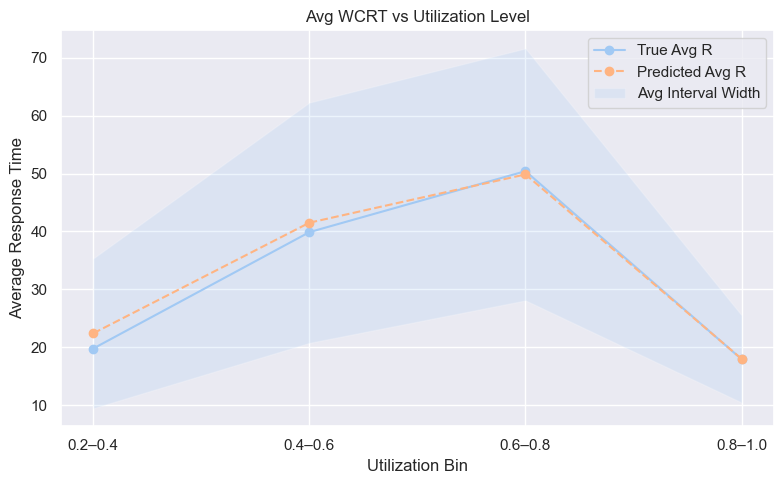


✅ Finished in 62.35 seconds.


In [151]:
# === STEP 1: Feature Engineering ===
def add_rt_features(df):
    df['C_div_T'] = df['C'] / df['T']
    df['slack'] = df['D'] - df['C']
    df['criticality'] = df['C'] / df['D']
    df['interference'] = df['C'] / df['T']
    df['C_squared'] = df['C'] ** 2
    df['T_over_D'] = df['T'] / df['D']
    df['interaction'] = df['C'] * df['hp_util']
    return df


# === STEP 2: Train or Load Quantile Model ===
def train_quantile_model(X_train, y_train, alpha, model_name):
    model_path = f"{model_name}.pkl"
    if os.path.exists(model_path):
        print(f"📦 Loading cached model: {model_path}")
        return joblib.load(model_path)
    print(f"🛠️ Training model: {model_name} (alpha={alpha})...")
    model = LGBMRegressor(
        objective='quantile',
        alpha=alpha,
        num_leaves=31,
        min_data_in_leaf=20,
        learning_rate=0.05,
        n_estimators=500,
        reg_alpha=0.1,
        reg_lambda=0.1,
        n_jobs=-1,
        verbose=-1
    )
    model.fit(X_train, y_train)
    joblib.dump(model, model_path)
    print(f"✅ Saved model: {model_path}")
    return model


# === STEP 3: Adaptive Calibration ===
def adaptive_calibration(X_calib, y_calib, preds_lower, preds_upper, alpha):
    bins = np.quantile(X_calib['U_total'], [0, 0.5, 1.0])
    bin_indices = np.digitize(X_calib['U_total'], bins)
    q_vals = []
    for b in np.unique(bin_indices):
        mask = (bin_indices == b)
        scores = np.maximum(y_calib[mask] - preds_upper[mask], preds_lower[mask] - y_calib[mask])
        q_val = np.quantile(scores, (1 - alpha) * 1.01, method='higher')
        q_vals.append(q_val)
    return bins, q_vals


# === STEP 4: Smart Optimization (Top 10%) ===
def smart_optimize_intervals(lower, upper, y_test, alpha, fraction=0.10):
    widths = upper - lower
    n_optimize = int(len(lower) * fraction)
    widest_idx = np.argsort(widths)[-n_optimize:]
    adjusted_upper = upper.copy()
    for i in widest_idx[::-1]:
        new_upper = lower[i] + (upper[i] - lower[i]) * 0.95
        temp_upper = adjusted_upper.copy()
        temp_upper[i] = new_upper
        if np.mean((y_test >= lower) & (y_test <= temp_upper)) >= (1 - alpha):
            adjusted_upper[i] = new_upper
    return adjusted_upper


# === MAIN PIPELINE ===
start_time = time.time()
print("🔄 Loading and preprocessing data...")
df = pd.read_csv("main_dataset.csv")
df_sched = df[df['schedulable'] == 1].copy()
df_sched = add_rt_features(df_sched)

# Features and Target
feature_cols = [
    'C', 'D', 'T', 'inv_T', 'hp_util', 'U_total', 'n_tasks',
    'C_div_T', 'slack', 'criticality', 'interference',
    'C_squared', 'T_over_D', 'interaction'
]
target_col = 'R_true'
X = df_sched[feature_cols]
y = df_sched[target_col]

print("📊 Splitting dataset...")
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=pd.qcut(X['U_total'], 5, duplicates='drop'), random_state=42
)
X_calib, X_test, y_calib, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=pd.qcut(X_temp['U_total'], 5, duplicates='drop'), random_state=42
)

# === Train or Load Models ===
alpha = 0.05
lower_model = train_quantile_model(X_train, y_train, alpha / 2, "cqr_lower_model")
upper_model = train_quantile_model(X_train, y_train, 1 - alpha / 2, "cqr_upper_model")

# === Calibration and Prediction ===
print("📏 Running adaptive calibration...")
preds_lower = lower_model.predict(X_calib)
preds_upper = upper_model.predict(X_calib)
bins, q_vals = adaptive_calibration(X_calib, y_calib, preds_lower, preds_upper, alpha)

print("🧠 Predicting on test set...")
test_lower = lower_model.predict(X_test)
test_upper = upper_model.predict(X_test)
test_bin = np.digitize(X_test['U_total'], bins)
test_lower_adj = test_lower - np.array([q_vals[b - 1] for b in test_bin])
test_upper_adj = test_upper + np.array([q_vals[b - 1] for b in test_bin])
y_pred = (test_lower_adj + test_upper_adj) / 2

# === Smart Optimization ===
if os.path.exists("optimized_upper_final.npy"):
    print("📦 Loading cached optimized intervals...")
    test_upper_final = np.load("optimized_upper_final.npy")
else:
    print("⚙️ Smart optimizing only top 10% widest intervals...")
    test_upper_final = smart_optimize_intervals(test_lower_adj, test_upper_adj, y_test, alpha)
    np.save("optimized_upper_final.npy", test_upper_final)

# === Evaluation ===
print("📈 Evaluating model...")
coverage = np.mean((y_test >= test_lower_adj) & (y_test <= test_upper_final))
avg_width = np.mean(test_upper_final - test_lower_adj)
max_width = np.max(test_upper_final - test_lower_adj)
mae = mean_absolute_error(y_test, y_pred)
max_error = np.max(np.abs(y_test - y_pred))

print("\n📊 IMPROVED CQR EVALUATION METRICS")
print("-----------------------------------")
print(f"MAE (mean abs error)       : {mae:.4f}")
print(f"Max Absolute Error         : {max_error:.4f}")
print(f"Coverage Rate (95% goal)   : {coverage * 100:.2f}%")
print(f"Average Interval Width     : {avg_width:.2f}")
print(f"Maximum Interval Width     : {max_width:.2f}")

# === Save Plot ===
print("📉 Plotting results...")
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:200], label='True R', marker='o', markersize=3, linestyle='')
plt.plot(y_pred[:200], label='Predicted R (midpoint)', linestyle='--')
plt.fill_between(np.arange(200), test_lower_adj[:200], test_upper_final[:200],
                 color='skyblue', alpha=0.5, label='95% Interval')
plt.xlabel("Sample Index")
plt.ylabel("Response Time")
plt.title("Improved CQR Interval Prediction (Sampled Test Points)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("improved_cqr_plot.png", dpi=300)
plt.show()

# === Safety Classification ===
is_safe = (y_test >= test_lower_adj) & (y_test <= test_upper_final)
safe_count = is_safe.sum()
unsafe_count = len(y_test) - safe_count
percent_safe = 100 * safe_count / len(y_test)

print("\n🔎 SAFETY PREDICTION DISTRIBUTION")
print("----------------------------------")
print(f"Safe Predictions     : {safe_count:,} ({percent_safe:.2f}%)")
print(f"Unsafe Predictions   : {unsafe_count:,} ({100 - percent_safe:.2f}%)")

# Optional Plot
plt.figure(figsize=(6, 4))
plt.bar(["Safe", "Unsafe"], [safe_count, unsafe_count], color=["green", "red"])
plt.ylabel("Number of Test Samples")
plt.title("Distribution of Safe vs Unsafe Predictions")
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("safety_distribution.png", dpi=300)
plt.show()

# === STEP 12: Average WCRT vs Utilization Level ===
print("\n📊 Average WCRT vs Utilization Level")

# Add true/pred to a DataFrame for grouped analysis
df_eval = X_test.copy()
df_eval["true_R"] = y_test.values
df_eval["pred_R"] = y_pred
df_eval["interval_width"] = test_upper_final - test_lower_adj

# Define utilization bins
bins = [0.2, 0.4, 0.6, 0.8, 1.0]
labels = ["0.2–0.4", "0.4–0.6", "0.6–0.8", "0.8–1.0"]
df_eval["util_bin"] = pd.cut(df_eval["U_total"], bins=bins, labels=labels, include_lowest=True)

# Group by bin
grouped = grouped = df_eval.groupby("util_bin", observed=True).agg({
    "true_R": "mean",
    "pred_R": "mean",
    "interval_width": "mean"
}).reset_index()

print(grouped)

# 📈 Plot
plt.figure(figsize=(8, 5))
plt.plot(grouped["util_bin"], grouped["true_R"], marker='o', label="True Avg R")
plt.plot(grouped["util_bin"], grouped["pred_R"], marker='o', linestyle='--', label="Predicted Avg R")
plt.fill_between(grouped["util_bin"].astype(str),
                 grouped["pred_R"] - grouped["interval_width"] / 2,
                 grouped["pred_R"] + grouped["interval_width"] / 2,
                 alpha=0.2, label="Avg Interval Width")
plt.xlabel("Utilization Bin")
plt.ylabel("Average Response Time")
plt.title("Avg WCRT vs Utilization Level")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("avg_wcrt_vs_util.png", dpi=300)
plt.show()

print(f"\n✅ Finished in {time.time() - start_time:.2f} seconds.")

In [153]:
def evaluate_on_new_dataset(csv_path, alpha=0.05):
    print(f"\n📥 Loading new dataset from {csv_path}")
    df_new = pd.read_csv(csv_path)
    df_new = df_new[df_new['schedulable'] == 1].copy()
    df_new = add_rt_features(df_new)

    feature_cols = [
        'C', 'D', 'T', 'inv_T', 'hp_util', 'U_total', 'n_tasks',
        'C_div_T', 'slack', 'criticality', 'interference',
        'C_squared', 'T_over_D', 'interaction'
    ]
    target_col = 'R_true'

    X_new = df_new[feature_cols]
    y_new = df_new[target_col]

    # Load trained models
    lower_model = joblib.load("../models/regression_models/cqr_lower_model.pkl")
    upper_model = joblib.load("../models/regression_models/cqr_upper_model.pkl")

    # Reuse calibration from training set
    print("📏 Re-calibrating with existing training data for adaptive q_hat...")
    df_train = pd.read_csv("main_dataset.csv")
    df_train = df_train[df_train['schedulable'] == 1].copy()
    df_train = add_rt_features(df_train)
    X_train = df_train[feature_cols]
    y_train = df_train[target_col]

    X_train, X_temp, y_train, y_temp = train_test_split(
        X_train, y_train, test_size=0.4, stratify=pd.qcut(df_train['U_total'], 5, duplicates='drop'), random_state=42
    )
    X_calib, _, y_calib, _ = train_test_split(
        X_temp, y_temp, test_size=0.5, stratify=pd.qcut(X_temp['U_total'], 5, duplicates='drop'), random_state=42
    )

    preds_lower = lower_model.predict(X_calib)
    preds_upper = upper_model.predict(X_calib)
    bins, q_vals = adaptive_calibration(X_calib, y_calib, preds_lower, preds_upper, alpha)

    # Predict on new dataset
    print("🧠 Predicting on new dataset...")
    new_lower = lower_model.predict(X_new)
    new_upper = upper_model.predict(X_new)
    test_bin = np.digitize(X_new['U_total'], bins)
    new_lower_adj = new_lower - np.array([q_vals[b - 1] for b in test_bin])
    new_upper_adj = new_upper + np.array([q_vals[b - 1] for b in test_bin])
    y_pred = (new_lower_adj + new_upper_adj) / 2

    # Smart optimization (optional)
    print("⚙️ Smart optimizing top 10% widest intervals...")
    new_upper_final = smart_optimize_intervals(new_lower_adj, new_upper_adj, y_new, alpha)

    # Evaluation
    coverage = np.mean((y_new >= new_lower_adj) & (y_new <= new_upper_final))
    avg_width = np.mean(new_upper_final - new_lower_adj)
    max_width = np.max(new_upper_final - new_lower_adj)
    mae = mean_absolute_error(y_new, y_pred)
    max_error = np.max(np.abs(y_new - y_pred))

    print("\n📊 NEW DATASET EVALUATION")
    print("----------------------------")
    print(f"MAE (mean abs error)       : {mae:.4f}")
    print(f"Max Absolute Error         : {max_error:.4f}")
    print(f"Coverage Rate (95% goal)   : {coverage * 100:.2f}%")
    print(f"Average Interval Width     : {avg_width:.2f}")
    print(f"Maximum Interval Width     : {max_width:.2f}")

    # Safety classification
    is_safe = (y_new >= new_lower_adj) & (y_new <= new_upper_final)
    safe_count = is_safe.sum()
    unsafe_count = len(y_new) - safe_count
    percent_safe = 100 * safe_count / len(y_new)

    print("\n🔎 SAFETY DISTRIBUTION ON NEW DATA")
    print("----------------------------------")
    print(f"Safe Predictions     : {safe_count:,} ({percent_safe:.2f}%)")
    print(f"Unsafe Predictions   : {unsafe_count:,} ({100 - percent_safe:.2f}%)")

    # Optional plot
    plt.figure(figsize=(6, 4))
    plt.bar(["Safe", "Unsafe"], [safe_count, unsafe_count], color=["green", "red"])
    plt.ylabel("Number of Test Samples")
    plt.title("Safety Prediction Distribution (New Data)")
    plt.grid(axis='y')
    plt.tight_layout()
    plt.savefig("new_data_safety_distribution.png", dpi=300)
    plt.show()

    return {
        "coverage": coverage,
        "mae": mae,
        "avg_width": avg_width,
        "max_width": max_width,
        "safe_percent": percent_safe,
        "n_samples": len(y_new)
    }


📁 Dataset already exists at: test_dataset.csv

📥 Loading new dataset from test_dataset.csv
📏 Re-calibrating with existing training data for adaptive q_hat...
🧠 Predicting on new dataset...
⚙️ Smart optimizing top 10% widest intervals...

📊 NEW DATASET EVALUATION
----------------------------
MAE (mean abs error)       : 7.6208
Max Absolute Error         : 271.3086
Coverage Rate (95% goal)   : 95.67%
Average Interval Width     : 30.21
Maximum Interval Width     : 499.26

🔎 SAFETY DISTRIBUTION ON NEW DATA
----------------------------------
Safe Predictions     : 313,883 (95.67%)
Unsafe Predictions   : 14,222 (4.33%)


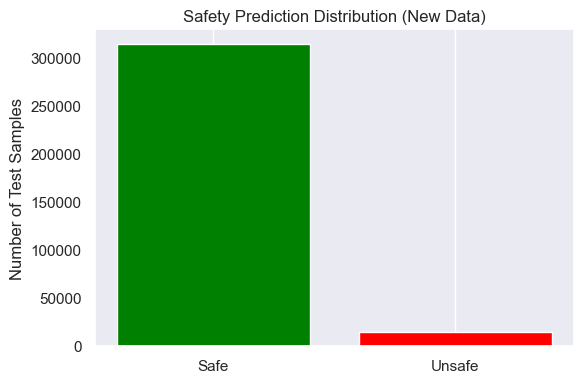

{'coverage': np.float64(0.9566541198701635), 'mae': 7.620756962604922, 'avg_width': np.float64(30.20588201155534), 'max_width': np.float64(499.2591198063012), 'safe_percent': np.float64(95.66541198701636), 'n_samples': 328105}


In [158]:
generate_dataset_csv("test_dataset.csv", samples_per_combination=500)
print(evaluate_on_new_dataset("../data/test_dataset.csv"))
